In [1]:
import sys
sys.path.append("../scripts")

import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

from boa.datasets.labels import label_names_dict

save_dir = "../plots/notebook_plots/ordering/"

In [29]:
def load_permutation_data(path, name, kind, matrix_factorized=False):
    
    with open(path) as f:
        gpar_data = pd.read_json(f)
        
        dfs = []
        for i, row in gpar_data.iterrows():
            
            if kind in ["greedy"]:
                df = pd.DataFrame({
                    'model': name + (("_" + str(row["latent_size"])) if matrix_factorized else ""),
                    'index': row['index'],
                    'output': row['outputs'],
                    'size': row["size"],
                    'perm': str(row["perm"]),
                    "train_time": row["train_time"],
                    "predict_time": row["predict_time"],
                    "rmse": row["rmse"],
                    "mean_abs_err": row["mean_abs_err"],
                    "mean_squ_err": row["mean_squ_err"],
                    
                    "search_mode": "greedy"
                })
            elif kind in ["random"]:
                df = pd.DataFrame({
                    'model': name + (("_" + str(row["latent_size"])) if matrix_factorized else ""),
                    'index': row['index'],
                    'output': row['outputs'],
                    'size': row["size"],
                    'perm': str(row["perm"]),
                    #"sample_stats": row["sample_stats"],
                    "train_time": row["train_time"],
                    "predict_time": row["predict_time"],
                    "rmse": row["rmse"],
                    "mean_abs_err": row["mean_abs_err"],
                    "mean_squ_err": row["mean_squ_err"],
                    
                    "search_mode": "random"
                })
            
            elif kind in ["bayesopt"]:
                raise NotImplementedError
            
            dfs.append(df)
        
    return pd.concat(dfs, axis=0, ignore_index=True)

In [3]:
def load_gpar_data(path, name, matrix_factorized=False):
    
    with open(path) as f:
        gpar_data = pd.read_json(f)
        
        dfs = []
        for i, row in gpar_data.iterrows():
            
            df = pd.DataFrame({
                'model': name + (("_" + str(row["latent_size"])) if matrix_factorized else ""),
                'index': row['index'],
                'output': row['outputs'],
                'size': row["size"],
                'perm': str(row["perm"]),
#                 "train_time": row["train_time"],
#                 "predict_time": row["predict_time"],
                "rmse": row["rmse"],
                "mean_abs_err": row["mean_abs_err"],
                "mean_squ_err": row["mean_squ_err"]
            })
            
            dfs.append(df)
        
    return pd.concat(dfs, axis=0, ignore_index=True)

In [4]:
def plot_stats(aggregate, stat: str, model: str, std=True):
    line_style_dict = {
        "gpar": "dashed",
        "gp_aux": "dotted",
        "mf_gpar_2": "dashdot",
        "mf_gpar_5": "dashdot",
        "mf_gpar_8": "dashdot"
    }
    
    line_color_dict = {
        "gpar": "black",
        "gp_aux": "black",
        "mf_gpar_2": "red",
        "mf_gpar_5": "green",
        "mf_gpar_8": "blue",
    }
    
    model_label = {
        "gpar": "GPAR",
        "gp_aux": "GP-aux",
        "mf_gpar_2": "MF-GPAR (2)",
        "mf_gpar_5": "MF-GPAR (5)",
        "mf_gpar_8": "MF-GPAR (8)"
    }
    
    outputs = ["avg_power", "cycle", "total_area"]
    
    fig, axes = plt.subplots(nrows=len(outputs), ncols=1, figsize=(16, 8 * len(outputs)))
    
    # Plot the outputs of interest
    for output, group in aggregate.groupby('output'):
        
        if output not in outputs: 
            continue
            
        ax = axes[outputs.index(output)]
        
        d = group.sort_values((stat, "median"))
        
        perm_range = range(stats["perm"].nunique())
        
        # Interpolated plot of performance
        ax.bar(perm_range,
               d[(stat, 'median')],
               label="Median")
        ax.set_xticks(perm_range)
        ax.set_xticklabels(list(d["perm"].unique()), rotation=90)
        # Plot error bars
        ax.errorbar(x=perm_range,
                    y=d[stat]['median'],
                    yerr=d[stat][["first_perc", "third_perc"]].T.to_numpy(),
                    ecolor=line_color_dict[model],
                   fmt='None',
                   capsize=3,
                   label="1st & 3rd quartiles")
        
        ax.bar(perm_range,
               d[(stat, 'mean')],
               alpha=0.5,
               label="Mean")
        
        if std:
            ax.errorbar(x=perm_range,
                        y=d[stat]['mean'],
                        yerr=d[stat]["std"],
                        ecolor='r',
                       fmt='None',
                       capsize=3,
                       label="1 $\sigma$")

            
        ax.set_ylabel('MAE '+ label_names_dict[output], fontsize=12)
        ax.set_xlabel('Permutations', fontsize=12)
            
        ax.set_xlim([-1, stats["perm"].nunique()])
        
        ax.legend()
        
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0.6)
    return fig

In [5]:
size = 100
search_mode = "random_search"

data_path = {
    "fft": "../logs/fft/ordering",
    "stencil3d": "../logs/stencil3d/ordering",
    "gemm": "../logs/gemm/ordering",
}

gpar_file = f"gpar_size_{size}_{search_mode}_experiments.json"
mf_gpar_2_file = f"mf-gpar-2_size_{size}_{search_mode}_experiments.json"
mf_gpar_5_file = f"mf-gpar-5_size_{size}_{search_mode}_experiments.json"
mf_gpar_8_file = f"mf-gpar-8_size_{size}_{search_mode}_experiments.json"

In [6]:
experiment_files = {
#     "fft": [("gpar", gpar_file),
#             #("mf_gpar", mf_gpar_2_file), 
# #             ("mf_gpar", mf_gpar_5_file), 
# #             ("mf_gpar", mf_gpar_8_file)
#     ],
    "stencil3d": [("gpar", gpar_file),
#                   ("mf_gpar", mf_gpar_5_file), 
    ],
#     "gemm": [("gpar", gpar_file),
#              #("mf_gpar", mf_gpar_5_file), 
#     ]
}

In [7]:
# Load the experiments data

experiment_data = {}

for task, task_list in experiment_files.items():

    dataframes = {}

    for name, file in task_list:
        dataframe = load_gpar_data(os.path.join(data_path[task], file), 
                                   name=name,
                                   matrix_factorized = name == "mf_gpar")
        
        dataframes[name] = dataframe

    experiment_data[task] = dataframes

FileNotFoundError: [Errno 2] No such file or directory: '../logs/stencil3d/ordering/gpar_size_100_random_search_experiments.json'

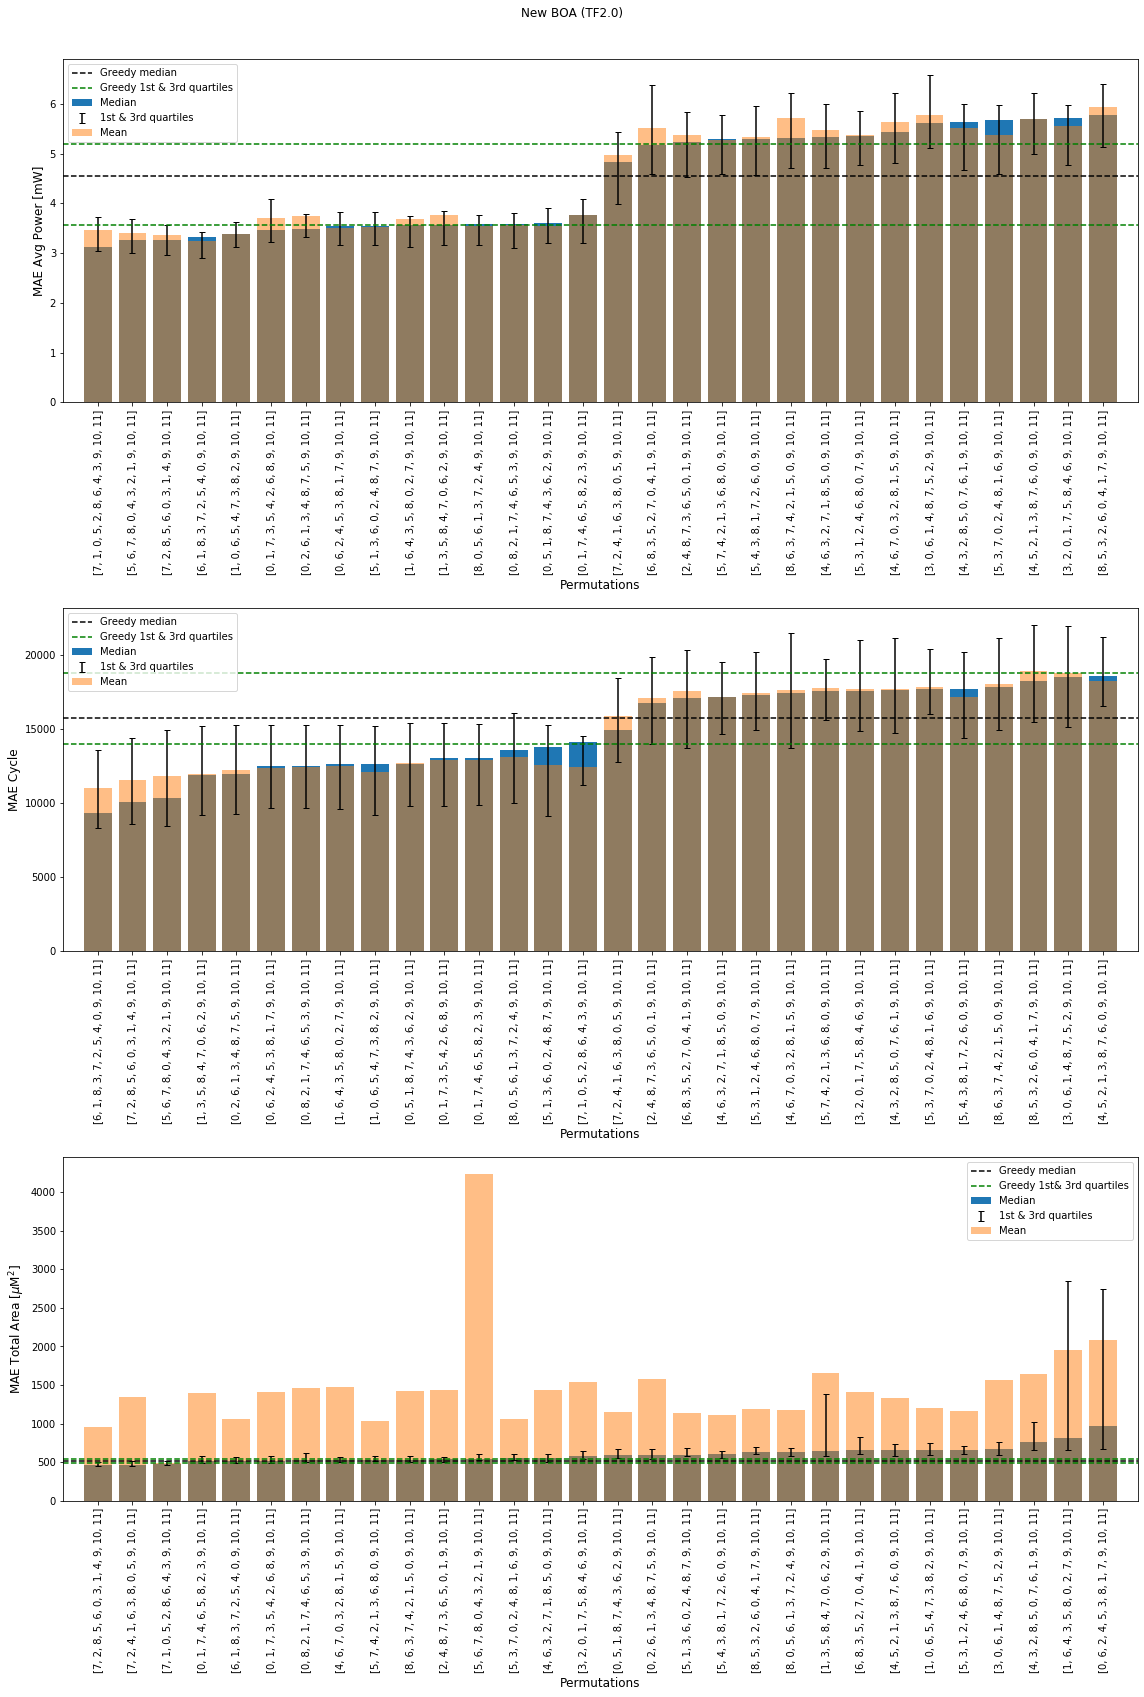

In [221]:
# Model comparison plots
for task, task_dict in experiment_data.items():
        
    task_save_dir = f"{save_dir}/{task}"
    
    if not os.path.exists(task_save_dir):
        os.makedirs(task_save_dir)
        

#     aggregated = pd.concat(task_dict, 
#                            sort=False, axis=0, ignore_index=True)

    for model, dataframe in task_dict.items():
        stats = dataframe.groupby(['output', 'perm'])
        stats = stats.aggregate({"mean_abs_err": {"mean": np.mean, 
                                                  "std": np.std, 
                                                  "first_perc": lambda x: np.median(x) - np.percentile(x, 25),
                                                  "median": lambda x: np.percentile(x, 50),
                                                  "third_perc":lambda x: np.percentile(x, 75) - np.median(x)}}).reset_index()

        fig = plot_stats(stats, stat="mean_abs_err", model=model, std=False)
        # TODO: take this out.
        # Ad-hoc Greedy median performance
        axes = fig.axes
        axes[0].axhline(greedy_stats.loc[greedy_stats['output'] == "avg_power"]["mean_abs_err"]["median"][5],
                        c='k',
                       linestyle='dashed',
                       label='Greedy median')
        axes[0].axhline(greedy_stats.loc[greedy_stats['output'] == "avg_power"]["mean_abs_err"]["first_perc"][5],
                        c='g',
                       linestyle='dashed',
                       label='Greedy 1st & 3rd quartiles')
        axes[0].axhline(greedy_stats.loc[greedy_stats['output'] == "avg_power"]["mean_abs_err"]["third_perc"][5],
                        c='g',
                       linestyle='dashed')
        axes[0].legend()
        
        
        axes[1].axhline(greedy_stats.loc[greedy_stats['output'] == "cycle"]["mean_abs_err"]["median"][6],
                        c='k',
                       linestyle='dashed',
                       label='Greedy median')
        axes[1].axhline(greedy_stats.loc[greedy_stats['output'] == "cycle"]["mean_abs_err"]["first_perc"][6],
                        c='g',
                       linestyle='dashed',
                       label='Greedy 1st & 3rd quartiles')
        axes[1].axhline(greedy_stats.loc[greedy_stats['output'] == "cycle"]["mean_abs_err"]["third_perc"][6],
                        c='g',
                       linestyle='dashed')
        axes[1].legend()
        
        
        axes[2].axhline(greedy_stats.loc[greedy_stats['output'] == "total_area"]["mean_abs_err"]["median"][11],
                        c='k',
                       linestyle='dashed',
                       label='Greedy median')
        axes[2].axhline(greedy_stats.loc[greedy_stats['output'] == "total_area"]["mean_abs_err"]["first_perc"][11],
                        c='g',
                       linestyle='dashed',
                       label='Greedy 1st& 3rd quartiles')
        axes[2].axhline(greedy_stats.loc[greedy_stats['output'] == "total_area"]["mean_abs_err"]["third_perc"][11],
                        c='g',
                       linestyle='dashed')
        axes[2].legend()
        
        fig.suptitle("New BOA (TF2.0)")
        fig.subplots_adjust(wspace=0.5, top=.95)

        fig.savefig(f"{task_save_dir}/{model}.png")
        
    plt.show()

In [217]:
greedy_dataframe = load_gpar_data(os.path.join(data_path["stencil3d"], "gpar_size_greedy_search_100_experiments.json"), 
                                   name=name,
                                   matrix_factorized = name == "mf_gpar")
greedy_dataframe['perm'].unique()

array(['[5, 7, 6, 2, 8, 3, 4, 0, 1, 9, 10, 11]',
       '[7, 5, 6, 2, 8, 0, 1, 3, 4, 9, 10, 11]',
       '[5, 7, 6, 2, 8, 1, 0, 3, 4, 9, 10, 11]',
       '[5, 7, 6, 2, 8, 0, 1, 3, 4, 9, 10, 11]',
       '[7, 5, 6, 2, 8, 4, 3, 0, 1, 9, 10, 11]',
       '[7, 5, 6, 2, 8, 3, 4, 0, 1, 9, 10, 11]',
       '[5, 7, 6, 2, 8, 0, 1, 4, 3, 9, 10, 11]'], dtype=object)

In [207]:
greedy_stats = greedy_dataframe.groupby(['model', 'output'])
greedy_stats = greedy_stats.aggregate({"mean_abs_err": {"mean": np.mean, 
                                          "std": np.std, 
                                          "first_perc": lambda x: np.percentile(x, 25),
                                          "median": lambda x: np.percentile(x, 50),
                                          "third_perc":lambda x: np.percentile(x, 75)}}).reset_index()

# fig = plot_stats(greedy_stats, stat="mean_abs_err", model=model)
# fig.suptitle("New BOA (TF2.0)")
# fig.subplots_adjust(wspace=0.5, top=.95)

In [30]:
greedy_df = load_permutation_data(os.path.join(data_path["stencil3d"], "gpar_train_100_valid_100_greedy_search_experiments.json"), 
                                  name=name,
                                  kind="greedy",
                                  matrix_factorized = name == "mf_gpar")

In [19]:
greedy_df = greedy_df.groupby(['model', 'output'])
greedy_df = greedy_df.aggregate({"mean_abs_err": {"mean": np.mean, 
                                  "std": np.std, 
                                  "first_perc": lambda x: np.percentile(x, 25),
                                  "median": lambda x: np.percentile(x, 50),
                                  "third_perc":lambda x: np.percentile(x, 75)}}).reset_index()

greedy_df

model                 output mean_abs_err                            \
                                        mean          std   first_perc   
0   gpar   avg_fu_dynamic_power     0.255810     0.095221     0.190018   
1   gpar   avg_fu_leakage_power     0.004825     0.000935     0.004413   
2   gpar  avg_mem_dynamic_power     2.792062     0.681296     2.223315   
3   gpar  avg_mem_leakage_power     0.007926     0.032281     0.000597   
4   gpar          avg_mem_power     2.790550     0.675041     2.225527   
5   gpar              avg_power     2.996195     0.736879     2.361523   
6   gpar                  cycle  9716.066583  4238.867866  6913.220759   
7   gpar                fu_area   390.035299    75.505249   356.861547   
8   gpar               fu_power     0.256762     0.095554     0.190736   
9   gpar               mem_area  1148.820557  2611.266633   220.463540   
10  gpar           num_register     2.033449     0.375248     1.864212   
11  gpar             total_area  1479.875602  2651.088345   529.549037   

                               
         median    third_perc  
0      0.200384      0.345546  
1      0.004501      0.004814  
2      2.765953      3.232012  
3      0.000653      0.000754  
4      2.762256      3.236846  
5      2.935719      3.451933  
6   7336.068770  12477.217801  
7    363.638151    389.123787  
8      0.202438      0.345887  
9    255.925533    313.396944  
10     1.901893      2.034572  
11   589.861033    674.696706

In [96]:
random_df = load_permutation_data(os.path.join(data_path["stencil3d"], "gpar_train_100_valid_100_random_search_experiments.json"), 
                                  name="gpar",
                                  kind="random",
                                  matrix_factorized=False)

In [97]:
aggregate_df = pd.concat([random_df, greedy_df], axis=0)
avg_power_df = aggregate_df.loc[aggregate_df["output"].isin(["avg_power"])]

avg_power_df = avg_power_df.melt(id_vars=["search_mode", "output"], 
                                 value_vars=['mean_abs_err', 'rmse'],
                                 var_name="error_kind")

cycle_df = aggregate_df.loc[aggregate_df["output"].isin(["cycle"])]

cycle_df = cycle_df.melt(id_vars=["search_mode", "output"], 
                                 value_vars=['mean_abs_err', 'rmse'],
                                 var_name="error_kind")

total_area_df = aggregate_df.loc[aggregate_df["output"].isin(["total_area"])]

total_area_df = total_area_df.melt(id_vars=["search_mode", "output"], 
                                 value_vars=['mean_abs_err', 'rmse'],
                                 var_name="error_kind")

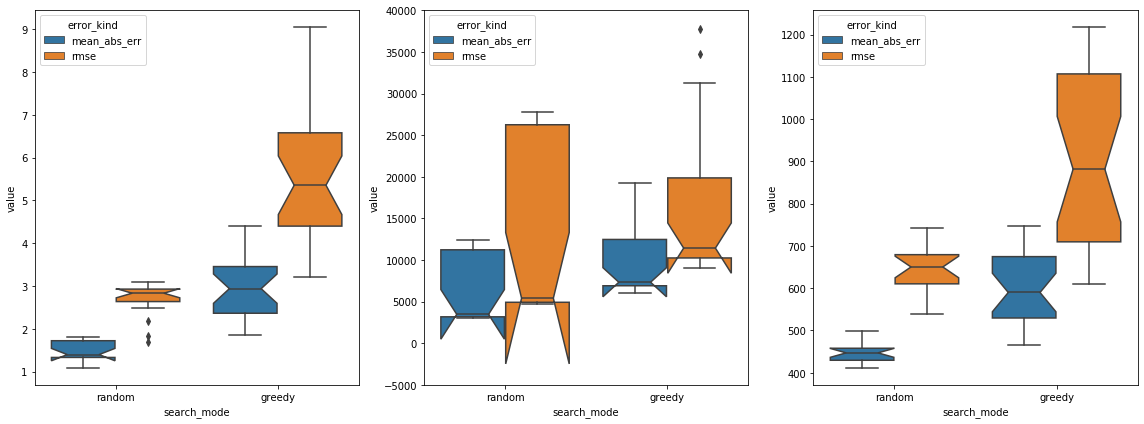

In [100]:
plt.figure(figsize=(16, 6))

plt.subplot(131)

sns.boxplot(x='search_mode', y='value', hue='error_kind', data=avg_power_df, notch=True)

plt.subplot(132)
sns.boxplot(x='search_mode', y='value', hue='error_kind', data=cycle_df, notch=True, whis=1.5)
plt.ylim([-5000, 40000])

plt.subplot(133)
sns.boxplot(x='search_mode', y='value', hue='error_kind', data=total_area_df, notch=True, whis=1.5, sym='')

plt.tight_layout()

plt.savefig(f"{save_dir}/stencil3d/random_vs_greedy.png")

plt.show()

In [99]:
random_df["perm"].nunique()

18